<a href="https://colab.research.google.com/github/ethandavenport/Optimization-I-Project-2/blob/main/Optimization_HW_pt_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 73.5 MB/s eta 0:00:00


In [4]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

In [5]:
url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/refs/heads/main/roi_company1.csv"
df_roi = pd.read_csv(url)

In [6]:
# Amounts are in MILLIONS of dollars (so budget=10 means $10M)
# --- Parameters (change if needed) ---
budget = 10.0        # total budget in millions
platform_cap = 3.0   # per-platform max in millions
bigM = budget        # big-M for "infinite" tiers (safe because total budget <= budget)

# Compute tier widths (maximum amount that can be placed in that tier)
def tier_width(row):
    if np.isfinite(row['UpperBound']):
        return max(0.0, row['UpperBound'] - row['LowerBound'])
    else:
        return bigM  # allow up to the whole budget for an "infinite" tier; platform cap will restrict
df_roi['Width'] = df_roi.apply(tier_width, axis=1)

# Build model
m = gp.Model()

# Decision vars: amount invested in each tier (millions)
vars_by_index = {}
for idx, row in df_roi.iterrows():
    name = f"x_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}"
    ub = row['Width']
    # some widths could be zero if Upper==Lower; skip creating vars that can't take anything
    if ub <= 0:
        v = m.addVar(lb=0.0, ub=0.0, name=name)
    else:
        v = m.addVar(lb=0.0, ub=ub, name=name)
    vars_by_index[idx] = v


# Objective: maximize total return = sum(ROI * invested_in_tier)
obj_expr = gp.quicksum(df_roi.loc[idx, 'ROI'] * vars_by_index[idx] for idx in vars_by_index)
m.setObjective(obj_expr, GRB.MAXIMIZE)

# 1) Total budget constraint
m.addConstr(gp.quicksum(vars_by_index[idx] for idx in vars_by_index) <= budget)

# Helper: platform -> list of tier indices
platform_to_indices = {}
for idx, row in df_roi.iterrows():
    platform_to_indices.setdefault(row['Platform'], []).append(idx)

# 2) Per-platform cap: total invested in each platform <= platform_cap
for platform, idx_list in platform_to_indices.items():
    m.addConstr(gp.quicksum(vars_by_index[idx] for idx in idx_list) <= platform_cap)

# Business constraints:
# a) Print + TV <= Facebook + Email
def platform_total(platform):
    idxs = platform_to_indices.get(platform, [])
    return gp.quicksum(vars_by_index[i] for i in idxs)

m.addConstr(platform_total('Print') + platform_total('TV') <= platform_total('Facebook') + platform_total('Email'))

# b) Social media (Facebook, LinkedIn, Instagram, Snapchat, Twitter) >= 2 * (SEO + AdWords)
social_platforms = ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter']
social_sum = gp.quicksum(platform_total(p) for p in social_platforms)
m.addConstr(social_sum >= 2.0 * (platform_total('SEO') + platform_total('AdWords')))

# Solve
m.Params.OutputFlag = 0 # tell gurobi to shut up!!
m.optimize()

# Print results
if m.status == GRB.OPTIMAL or m.status == GRB.TIME_LIMIT or m.status == GRB.SUBOPTIMAL:
    print('\n=== Optimal allocation (amounts in MILLIONS) ===')
    # Per-platform totals
    platform_alloc = {}
    for platform, idxs in platform_to_indices.items():
        total = sum(vars_by_index[i].X for i in idxs)
        platform_alloc[platform] = total
        print(f"{platform:10s}: {total:.4f} (per-tier breakdown below)")
        for i in idxs:
            invested = vars_by_index[i].X
            if invested > 1e-8:
                row = df_roi.loc[i]
                print(f"   tier {int(row['Tier'])}: {invested:.4f}  (ROI={row['ROI']:.4f}, width={row['Width']:.2f})")
    total_invested = sum(v.X for v in vars_by_index.values())
    total_return = sum(df_roi.loc[i, 'ROI'] * vars_by_index[i].X for i in vars_by_index)
    print(f"\nTotal invested: {total_invested:.4f} / {budget:.4f} (M)")
    print(f"Estimated total return: {total_return:.6f} (in MILLIONS of dollars returned)")
    # If you want dollar-level return, multiply by 1e6
else:
    print("Model did not solve to optimality. Status:", m.status)

Restricted license - for non-production use only - expires 2026-11-23

=== Optimal allocation (amounts in MILLIONS) ===
Print     : 0.0000 (per-tier breakdown below)
TV        : 3.0000 (per-tier breakdown below)
   tier 1: 3.0000  (ROI=0.0608, width=4.30)
SEO       : 0.0000 (per-tier breakdown below)
AdWords   : 1.0000 (per-tier breakdown below)
   tier 1: 1.0000  (ROI=0.0419, width=2.00)
Facebook  : 0.0000 (per-tier breakdown below)
LinkedIn  : 0.0000 (per-tier breakdown below)
Instagram : 3.0000 (per-tier breakdown below)
   tier 1: 2.9000  (ROI=0.0574, width=2.90)
   tier 2: 0.1000  (ROI=0.0498, width=10.00)
Snapchat  : 0.0000 (per-tier breakdown below)
Twitter   : 0.0000 (per-tier breakdown below)
Email     : 3.0000 (per-tier breakdown below)
   tier 1: 3.0000  (ROI=0.0493, width=5.90)

Total invested: 10.0000 / 10.0000 (M)
Estimated total return: 0.543640 (in MILLIONS of dollars returned)


In [7]:
url2 = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/refs/heads/main/roi_company2.csv"
df_roi2 = pd.read_csv(url2)

# -----------------------------
# SETUP (amounts in MILLIONS)
# -----------------------------
budget = 10.0        # total budget in millions
platform_cap = 3.0   # per-platform max in millions
bigM = budget        # safe big-M for "inf" tiers

# Ensure Width exists (based on df_roi2)
def tier_width(row):
    if np.isfinite(row['UpperBound']):
        return max(0.0, row['UpperBound'] - row['LowerBound'])
    else:
        return bigM  # allow up to whole budget for "inf"
df2 = df_roi2.copy()
df2['Width'] = df2.apply(tier_width, axis=1)

# -----------------------------
# BUILD MODEL FROM df_roi2 ONLY
# -----------------------------
m_mip = gp.Model() # Use a different model name for MIP
m_mip.Params.OutputFlag = 0

# Decision vars: amount invested in each tier (millions)
vars_by_index_mip = {} # Use a different variable name for MIP vars
for idx, row in df2.iterrows():
    name = f"x_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}"
    ub = float(row['Width'])
    # keep same pattern as your LP
    if ub <= 0:
        v = m_mip.addVar(lb=0.0, ub=0.0, name=name)
    else:
        v = m_mip.addVar(lb=0.0, ub=ub, name=name)
    vars_by_index_mip[idx] = v

# Objective: maximize total return = sum(ROI * invested_in_tier)
obj_expr = gp.quicksum(df2.loc[idx, 'ROI'] * vars_by_index_mip[idx] for idx in vars_by_index_mip)
m_mip.setObjective(obj_expr, GRB.MAXIMIZE)

# Helper: platform -> list of tier indices (built from df_roi2)
platform_to_indices_mip = {} # Use a different name for MIP indices
for idx, row in df2.iterrows():
    platform_to_indices_mip.setdefault(row['Platform'], []).append(idx)

# -----------------------------
# SAME BUSINESS CONSTRAINTS
# -----------------------------
# 1) Total budget
m_mip.addConstr(gp.quicksum(vars_by_index_mip[idx] for idx in vars_by_index_mip) <= budget)

# 2) Per-platform cap
for platform, idx_list in platform_to_indices_mip.items():
    m_mip.addConstr(gp.quicksum(vars_by_index_mip[idx] for idx in idx_list) <= platform_cap)

# (a) Print + TV <= Facebook + Email
def platform_total_mip(p): # Use a different name for MIP platform total
    idxs = platform_to_indices_mip.get(p, [])
    return gp.quicksum(vars_by_index_mip[i] for i in idxs)

m_mip.addConstr(
    platform_total_mip('Print') + platform_total_mip('TV')
    <= platform_total_mip('Facebook') + platform_total_mip('Email')
)

# (b) Social >= 2 * (SEO + AdWords)
social_platforms = ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter']
social_sum = gp.quicksum(platform_total_mip(p) for p in social_platforms)
m_mip.addConstr(social_sum >= 2.0 * (platform_total_mip('SEO') + platform_total_mip('AdWords')))

# -----------------------------
# MIP ADD-ON: NO SKIPPING
# -----------------------------
# 1) Binary activation per tier
z_by_index = {}
for idx, row in df2.iterrows():
    z_by_index[idx] = m_mip.addVar(vtype=GRB.BINARY,
                               name=f"z_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}")

# 2) Gate: no spend unless tier is on
for idx, row in df2.iterrows():
    m_mip.addConstr(vars_by_index_mip[idx] <= row['Width'] * z_by_index[idx],
                name=f"gate_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}")

# 3) Chain (no activation skipping): if higher tier is on, lower must be on  -> z_prev >= z_next
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    idx_list_sorted = sorted(
        idx_list,
        key=lambda k: (float(df2.loc[k, 'LowerBound']), int(df2.loc[k, 'Tier']))
    )
    for prev_idx, next_idx in zip(idx_list_sorted[:-1], idx_list_sorted[1:]):
        m_mip.addConstr(z_by_index[prev_idx] >= z_by_index[next_idx],
                    name=f"order_{platform}_t{int(df2.loc[prev_idx,'Tier'])}_to_t{int(df2.loc[next_idx,'Tier'])}")

# 4) Fill-up (no spend skipping): must fully fund tier j before any spend in tier j+1
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    idx_list_sorted = sorted(
        idx_list,
        key=lambda k: (float(df2.loc[k, 'LowerBound']), int(df2.loc[k, 'Tier']))
    )
    for prev_idx, next_idx in zip(idx_list_sorted[:-1], idx_list_sorted[1:]):
        m_mip.addConstr(
            vars_by_index_mip[prev_idx] >= df2.loc[prev_idx, 'Width'] * z_by_index[next_idx],
            name=f"fill_{platform}_t{int(df2.loc[prev_idx,'Tier'])}_before_t{int(df2.loc[next_idx,'Tier'])}"
        )



# -----------------------------
# SOLVE + CLEAN REPORT
# -----------------------------
m_mip.optimize()

EPS = 1e-9
print(f"Objective (total return): {m_mip.objVal:,.6f}")
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    invested = sum(vars_by_index_mip[i].X for i in idx_list)
    tiers_on = sorted([int(df2.loc[i, 'Tier']) for i in idx_list if vars_by_index_mip[i].X > EPS])
    print(f"{platform:12s}  invested={invested:,.3f}M   tiers_on={tiers_on}")

Objective (total return): 0.452827
Print         invested=3.000M   tiers_on=[1, 2]
TV            invested=0.000M   tiers_on=[]
SEO           invested=0.000M   tiers_on=[]
AdWords       invested=2.333M   tiers_on=[1, 2]
Facebook      invested=3.000M   tiers_on=[1]
LinkedIn      invested=1.667M   tiers_on=[1]
Instagram     invested=0.000M   tiers_on=[]
Snapchat      invested=0.000M   tiers_on=[]
Twitter       invested=0.000M   tiers_on=[]
Email         invested=0.000M   tiers_on=[]


In [8]:
# Scenario 1: Objective using df_roi with allocation from df_roi2 (MIP)

# Get allocation from the MIP model (vars_by_index_mip)
# Use the platform_to_indices_mip created for df_roi2 in cell 33aHki4hS7_s
# Ensure cell 33aHki4hS7_s has been executed to define vars_by_index_mip and platform_to_indices_mip
mip_allocation = {df2.loc[idx, 'Platform']: {df2.loc[idx, 'Tier']: var.X for idx, var in vars_by_index_mip.items() if var.X > 1e-9}
                  for platform, idx_list in platform_to_indices_mip.items()}

# Calculate objective using df_roi and mip_allocation
total_return_roi1_mip_alloc = 0
for idx, row in df_roi.iterrows():
    platform = row['Platform']
    tier = row['Tier']
    roi = row['ROI']
    # Find the allocated amount for this tier in the MIP allocation
    allocated_amount = mip_allocation.get(platform, {}).get(tier, 0)
    total_return_roi1_mip_alloc += roi * allocated_amount

print(f"Objective using df_ROI with allocation from df_ROI2 (MIP): {total_return_roi1_mip_alloc:,.6f}")

# Scenario 2: Objective using df_roi2 with allocation from df_roi (LP)

# Get allocation from the LP model (vars_by_index_lp)
# Use the platform_to_indices_lp created for df_roi in cell Zb0hiaVdjlB6
# Ensure cell Zb0hiaVdjlB6 has been executed to define vars_by_index_lp and platform_to_indices_lp
lp_allocation = {df_roi.loc[idx, 'Platform']: {df_roi.loc[idx, 'Tier']: var.X for idx, var in vars_by_index.items() if var.X > 1e-9}
                 for platform, idx_list in platform_to_indices.items()}

# Calculate objective using df_roi2 and lp_allocation
total_return_roi2_lp_alloc = 0
for idx, row in df_roi2.iterrows():
    platform = row['Platform']
    tier = row['Tier']
    roi = row['ROI']
    # Find the allocated amount for this tier in the LP allocation
    allocated_amount = lp_allocation.get(platform, {}).get(tier, 0)
    total_return_roi2_lp_alloc += roi * allocated_amount

print(f"Objective using df_ROI2 with allocation from df_ROI (LP): {total_return_roi2_lp_alloc:,.6f}")

Objective using df_ROI with allocation from df_ROI2 (MIP): 0.128067
Objective using df_ROI2 with allocation from df_ROI (LP): 0.076150


Graphs for Report

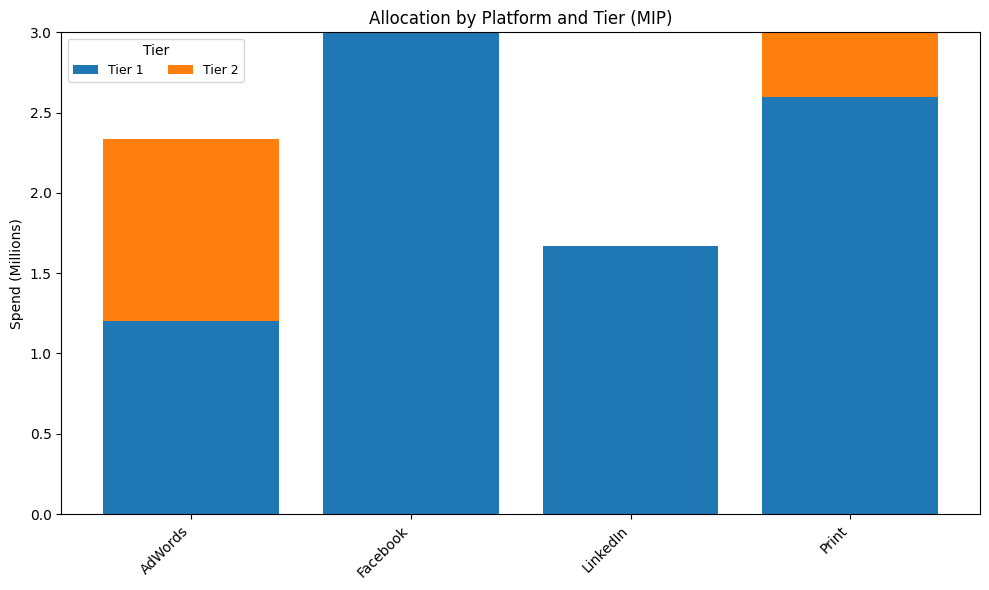


Allocation summary (for report):


,TotalSpendM,TiersOn
Platform,,
AdWords,2.333333,"[1, 2]"
Facebook,3.000000,[1]
LinkedIn,1.666667,[1]
Print,3.000000,"[1, 2]"


In [9]:
# -----------------------------
# GRAPH: Spend by Tier per Platform (stacked bars)
# -----------------------------
import matplotlib.pyplot as plt

EPS = 1e-9

# Build a tidy allocation table from the solved model
alloc_rows = []
for platform, idx_list in platform_to_indices.items():
    for i in idx_list:
        spend = float(vars_by_index_mip[i].X)
        if spend > EPS:
            alloc_rows.append({
                "Platform": platform,
                "Tier": int(df2.loc[i, "Tier"]),
                "SpendM": spend,
                "ROI": float(df2.loc[i, "ROI"])
            })

alloc_df = pd.DataFrame(alloc_rows)

# If nothing was invested (edge case), still create an empty frame
if alloc_df.empty:
    alloc_df = pd.DataFrame(columns=["Platform", "Tier", "SpendM", "ROI"])

# Pivot to Platform x Tier for stacked plotting
spend_pivot = (
    alloc_df
    .pivot_table(index="Platform", columns="Tier", values="SpendM", aggfunc="sum", fill_value=0.0)
    .sort_index(axis=1)  # sort tiers ascending for consistent stacked order
    .sort_index(axis=0)  # sort platforms alphabetically
)

# Plot stacked bars
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(spend_pivot))
x = np.arange(len(spend_pivot.index))
for tier in spend_pivot.columns:
    heights = spend_pivot[tier].values
    plt.bar(x, heights, bottom=bottom, label=f"Tier {tier}")
    bottom += heights

plt.xticks(x, spend_pivot.index, rotation=45, ha="right")
plt.ylabel("Spend (Millions)")
plt.title("Allocation by Platform and Tier (MIP)")
plt.legend(title="Tier", ncols=3, fontsize=9, title_fontsize=10)
plt.tight_layout()
# Optional: save for the report
# plt.savefig("allocation_by_platform_tiers.png", dpi=200, bbox_inches="tight")
plt.show()

# -----------------------------
# TABLE: Totals & Active Tiers (for report appendix)
# -----------------------------
totals = spend_pivot.sum(axis=1).rename("TotalSpendM")
active_tiers = (
    (spend_pivot > EPS)
    .apply(lambda row: [int(c) for c in spend_pivot.columns[row.values]], axis=1)
    .rename("TiersOn")
)
summary_tbl = pd.concat([totals, active_tiers], axis=1)
print("\nAllocation summary (for report):")
display(summary_tbl)


***Question 7:***

Your boss has gained permission to reinvest half of the return. For example, if the marketing
obtains a 4% return in January, the budget of February will be $10M + $10M × 4% × 50% =
$10.2M. The monthly ROI for next year is given in the file “roi_monthly.csv”. The three
constraints given by your boss and the constraint for the minimum amounts are still in place for
each month. You do not need to implement the minimum amount constraint in Part 6). What is
the optimal allocation for each month?

In [10]:
url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/main/roi_company1.csv"
df_roi = pd.read_csv(url)

url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/main/roi_company2.csv"
df_roi2 = pd.read_csv(url)

url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/main/roi_monthly.csv"
df_month = pd.read_csv(url)

url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/main/min_amount.csv"
df_min = pd.read_csv(url)

In [11]:
# Replace 'inf' with 3.0 cap (per-medium max investment)
df_roi["UpperBound"] = df_roi["UpperBound"].replace("inf", np.inf)
df_roi["UpperBound"] = df_roi["UpperBound"].astype(float)
df_roi.loc[df_roi["UpperBound"] == np.inf, "UpperBound"] = 3.0

# Now compute finite widths
df_roi["Width"] = df_roi["UpperBound"] - df_roi["LowerBound"]

# Clean up 'inf' and ensure numeric types
df_roi["UpperBound"] = df_roi["UpperBound"].replace("inf", np.inf)
df_roi["Tier"] = df_roi["Tier"].astype(int)

# Compute width per tier (investment range)
df_roi["Width"] = df_roi["UpperBound"] - df_roi["LowerBound"]

# Platform/tier dictionaries
roi = df_roi.set_index(["Platform", "Tier"])["ROI"].to_dict()
width = df_roi.set_index(["Platform", "Tier"])["Width"].to_dict()
min_invest = df_min.set_index("Platform")["MinInvestment"].to_dict()

platforms = df_roi["Platform"].unique().tolist()
budget = 10  # total $10M

# --- Build model ---
m = gp.Model("Marketing_Optimization")

# Create decision variables only for existing tiers
x = {}
z = {}
for (p, t), _ in roi.items():
    x[p, t] = m.addVar(lb=0, name=f"x_{p}_{t}")
    z[p, t] = m.addVar(vtype=GRB.BINARY, name=f"z_{p}_{t}")

# Platform-level binary variable
y = {p: m.addVar(vtype=GRB.BINARY, name=f"y_{p}") for p in platforms}

# --- Objective ---
m.setObjective(
    gp.quicksum(roi[p, t] * x[p, t] for (p, t) in roi),
    GRB.MAXIMIZE
)

# --- Constraints ---

# 1. Total budget
m.addConstr(gp.quicksum(x[p, t] for (p, t) in roi) == budget, "Budget")

# 2. Tier logic (fill lower before higher)
for p in platforms:
    platform_tiers = sorted(df_roi.loc[df_roi["Platform"] == p, "Tier"])
    for t in platform_tiers:
        # can't exceed width if active
        m.addConstr(x[p, t] <= width[p, t] * z[p, t], f"Width_{p}_{t}")
        # link sequential tiers
        if t > min(platform_tiers):
            m.addConstr(x[p, t-1] >= width[p, t-1] * z[p, t], f"Seq_{p}_{t}")

# 3. Min/max per-platform
for p in platforms:
    tiers_p = [t for t in df_roi.loc[df_roi["Platform"] == p, "Tier"]]
    total_p = gp.quicksum(x[p, t] for t in tiers_p)
    m.addConstr(total_p >= min_invest[p] * y[p], f"Min_{p}")
    m.addConstr(total_p <= 3 * y[p], f"Cap_{p}")
    if (p, 1) in z:
        m.addConstr(z[p, 1] <= y[p], f"Activate_{p}")

# 4. Managerial constraints
def total(p):
    if p not in platforms:
        return 0
    tiers_p = [t for t in df_roi.loc[df_roi["Platform"] == p, "Tier"]]
    return gp.quicksum(x[p, t] for t in tiers_p)

m.addConstr(total("Print") + total("TV") <= total("Facebook") + total("Email"), "PrintTV")
social = total("Facebook") + total("LinkedIn") + total("Instagram") + total("Snapchat") + total("Twitter")
search = total("SEO") + total("AdWords")
m.addConstr(social >= 2 * search, "SocialVsSearch")

# --- Solve ---
m.Params.OutputFlag = 0 # tell gurobi to shut up!!
m.optimize()

# --- Output ---
if m.status == GRB.OPTIMAL:
    print(f"\nOptimal total return: {m.objVal:.4f}\n")
    results = []
    for p in platforms:
        tiers_p = [t for t in df_roi.loc[df_roi["Platform"] == p, "Tier"]]
        invest = sum(x[p, t].x for t in tiers_p)
        active_tiers = [t for t in tiers_p if z[p, t].x > 0.5]
        results.append((p, invest, active_tiers))
    df_out = pd.DataFrame(results, columns=["Platform", "TotalInvestment", "ActiveTiers"])
    print(df_out.sort_values("TotalInvestment", ascending=False))



Optimal total return: 0.5436

    Platform  TotalInvestment ActiveTiers
1         TV              3.0         [1]
9      Email              3.0         [1]
6  Instagram              3.0      [1, 2]
3    AdWords              1.0         [1]
0      Print              0.0          []
2        SEO              0.0          []
5   LinkedIn              0.0          []
4   Facebook              0.0          []
7   Snapchat              0.0          []
8    Twitter              0.0          []


In [12]:
# Clean 'inf' and numeric types
df_month["UpperBoundM"] = df_month["UpperBoundM"].replace("inf", np.inf)
df_month["UpperBoundM"] = df_month["UpperBoundM"].astype(float)
df_month.loc[df_month["UpperBoundM"] == np.inf, "UpperBoundM"] = 10.0  # cap per-platform
df_month["Tier"] = df_month["Tier"].astype(int)
df_month["Width"] = df_month["UpperBoundM"] - df_month["LowerBoundM"]

months = df_month["Month"].unique().tolist()
budget = 10.0

monthly_results = []
monthly_allocations = []

# List of all platforms (for consistent columns)
all_platforms = df_month["Platform"].unique().tolist()
all_tiers = [1,2,3,4]  # maximum number of tiers

for month in months:
    print(f"\n===== {month} =====")
    df_m = df_month[df_month["Month"] == month].copy()
    platforms = df_m["Platform"].unique().tolist()
    roi = df_m.set_index(["Platform", "Tier"])["ROI"].to_dict()
    width = df_m.set_index(["Platform", "Tier"])["Width"].to_dict()

    # --- Build model ---
    m = gp.Model(f"Marketing_{month}")
    x = {}
    z = {}

    for (p, t), _ in roi.items():
        x[p, t] = m.addVar(lb=0, name=f"x_{p}_{t}")
        z[p, t] = m.addVar(vtype=GRB.BINARY, name=f"z_{p}_{t}")

    # Objective
    m.setObjective(gp.quicksum(roi[p, t] * x[p, t] for (p, t) in roi), GRB.MAXIMIZE)

    # Budget
    m.addConstr(gp.quicksum(x[p, t] for (p, t) in roi) == budget, "Budget")

    # Tier constraints
    for p in platforms:
      platform_tiers = sorted(df_m.loc[df_m["Platform"] == p, "Tier"])
      for i, t in enumerate(platform_tiers):
          # Tier t cannot exceed its width if activated
          m.addConstr(x[p, t] <= width[p, t] * z[p, t], f"Width_{p}_{t}")

          # Sequential tier activation: previous tier must be fully invested
          if i > 0:  # tier index > 0 means t>1
              t_prev = platform_tiers[i-1]
              m.addConstr(x[p, t_prev] >= width[p, t_prev] * z[p, t], f"Seq_{p}_{t}")

      # Platform cap <= 3M
      m.addConstr(gp.quicksum(x[p, t] for t in platform_tiers) <= 3, f"Cap_{p}")

      # --- NEW: enforce z=0 if total investment = 0 ---
      m.addConstr(gp.quicksum(x[p, t] for t in platform_tiers) <= 3 * gp.quicksum(z[p, t] for t in platform_tiers),
                f"ZeroInvest_{p}")

    # Managerial constraints
    def total(p):
        if p not in platforms:
            return 0
        tiers_p = [t for t in df_m.loc[df_m["Platform"] == p, "Tier"]]
        return gp.quicksum(x[p, t] for t in tiers_p)

    m.addConstr(total("Print") + total("TV") <= total("Facebook") + total("Email"), "PrintTV")
    social = total("Facebook") + total("LinkedIn") + total("Instagram") + total("Snapchat") + total("Twitter")
    search = total("SEO") + total("AdWords")
    m.addConstr(social >= 2 * search, "SocialVsSearch")

    # Solve
    m.setParam("OutputFlag", 0)
    m.optimize()

    if m.status == GRB.OPTIMAL:
        total_return = m.objVal
        roi_percent = total_return / budget
        new_budget = budget * (1 + 0.5 * roi_percent)

        print(f"Budget: ${budget:.4f}M | Return: ${total_return:.6f}M | ROI: {roi_percent*100:.2f}% | Next budget: ${new_budget:.4f}M")

        # --- Continuous investment matrix ---
        x_matrix = pd.DataFrame(index=all_platforms, columns=all_tiers)
        for p in all_platforms:
            for t in all_tiers:
                if (p, t) in x:
                    x_matrix.at[p, t] = x[p, t].x
                else:
                    x_matrix.at[p, t] = 0.0
        print("\nContinuous Investment Matrix (x):")
        print(x_matrix.round(4))

        # --- Binary decision matrix ---
        z_matrix = pd.DataFrame(index=all_platforms, columns=all_tiers)
        for p in all_platforms:
            for t in all_tiers:
                if (p, t) in z:
                    z_matrix.at[p, t] = z[p, t].x
                else:
                    z_matrix.at[p, t] = 0
        print("\nBinary Decision Matrix (z):")
        print(z_matrix.round(0))

        # Record per-platform allocation
        for p in all_platforms:
            tiers_p = df_m.loc[df_m["Platform"] == p, "Tier"].tolist()
            invest = sum(x[p, t].x for t in tiers_p) if p in platforms else 0.0
            monthly_allocations.append({
                "Month": month,
                "Platform": p,
                "Investment": invest
            })

        monthly_results.append({
            "Month": month,
            "Budget(M$)": budget,
            "Return(M$)": total_return
        })

        # Update budget for next month
        budget = new_budget

# --- Create final table ---
df_alloc = pd.DataFrame(monthly_allocations)
df_summary = pd.DataFrame(monthly_results)
df_alloc_pivot = df_alloc.pivot(index="Month", columns="Platform", values="Investment").fillna(0)
df_final = df_summary.merge(df_alloc_pivot, left_on="Month", right_index=True)

# Sort columns nicely
cols_order = ["Month", "Budget(M$)", "Return(M$)"] + sorted(all_platforms)
df_final = df_final[cols_order].round(4)

print("\n===== FINAL ALLOCATION TABLE =====")
df_final



===== Jan =====
Budget: $10.0000M | Return: $0.539420M | ROI: 5.39% | Next budget: $10.2697M

Continuous Investment Matrix (x):
             1    2    3    4
Print      3.0  0.0  0.0  0.0
TV         0.0  0.0  0.0  0.0
SEO        0.0  0.0  0.0  0.0
AdWords    0.0  0.0  0.0  0.0
Facebook   3.0  0.0  0.0  0.0
LinkedIn   0.4  2.2  0.4  0.0
Instagram  0.0  0.0  0.0  0.0
Snapchat   0.0  0.0  0.0  0.0
Twitter    1.0  0.0  0.0  0.0
Email      0.0  0.0  0.0  0.0

Binary Decision Matrix (z):
             1    2    3    4
Print      1.0  0.0    0    0
TV         1.0  0.0    0    0
SEO        1.0  0.0  0.0  0.0
AdWords    1.0  0.0  0.0    0
Facebook   1.0  0.0    0    0
LinkedIn   1.0  1.0  1.0    0
Instagram  1.0  0.0  0.0    0
Snapchat   1.0  0.0  0.0  0.0
Twitter    1.0  0.0  0.0    0
Email      1.0  0.0  0.0  0.0

===== Feb =====
Budget: $10.2697M | Return: $0.420890M | ROI: 4.10% | Next budget: $10.4802M

Continuous Investment Matrix (x):
                 1        2    3    4
Print          

,Month,Budget(M$),Return(M$),AdWords,Email,Facebook,Instagram,LinkedIn,Print,SEO,Snapchat,TV,Twitter
0,Jan,10.0000,0.5394,0.0000,0.0000,3.0000,0.0000,3.0,3.0000,0.0,0.0000,0.0,1.0000
1,Feb,10.2697,0.4209,2.6566,0.0000,3.0000,0.0000,2.1,2.3000,0.0,0.2131,0.0,0.0000
2,Mar,10.4802,0.5488,2.6960,0.0000,2.3921,0.0000,3.0,2.3921,0.0,0.0000,0.0,0.0000
3,Apr,10.7545,0.5237,1.7545,0.0000,3.0000,0.0000,3.0,3.0000,0.0,0.0000,0.0,0.0000
4,May,11.0164,0.6315,0.0000,3.0000,0.0000,2.0164,3.0,3.0000,0.0,0.0000,0.0,0.0000
5,Jun,11.3322,0.5305,0.0000,0.0000,3.0000,0.0000,3.0,3.0000,0.0,0.0000,0.0,2.3322
6,Jul,11.5974,0.6114,0.0000,0.0000,3.0000,0.0000,3.0,2.5974,3.0,0.0000,0.0,0.0000
7,Aug,11.9031,0.6167,3.0000,0.0000,0.6000,0.0000,3.0,0.6000,0.0,1.7031,0.0,3.0000
8,Sep,12.2115,0.6519,2.3705,2.1000,0.9000,0.8410,3.0,3.0000,0.0,0.0000,0.0,0.0000
9,Oct,12.5374,0.7483,0.0000,0.5374,3.0000,0.0000,3.0,3.0000,0.0,0.0000,0.0,3.0000


In [13]:
3*.0512 + 0.4*0.0487 + 2.2*0.0559 + 0.4*0.0564 + 3*0.0571 + 1*0.0496

0.53952

In [14]:
df_month[df_month['Month'] == "Jan"].sort_values(by='ROI', ascending=False)

,Month,Platform,Tier,LowerBoundM,UpperBoundM,ROI,Width
1,Jan,Print,2,6.0,10.0,0.0593,4.0
0,Jan,Print,1,0.0,6.0,0.0571,6.0
15,Jan,LinkedIn,3,2.6,10.0,0.0564,7.4
14,Jan,LinkedIn,2,0.4,2.6,0.0559,2.2
25,Jan,Twitter,3,3.7,10.0,0.0541,6.3
12,Jan,Facebook,2,4.2,10.0,0.0531,5.8
11,Jan,Facebook,1,0.0,4.2,0.0512,4.2
24,Jan,Twitter,2,2.4,3.7,0.0498,1.3
23,Jan,Twitter,1,0.0,2.4,0.0495,2.4
13,Jan,LinkedIn,1,0.0,0.4,0.0487,0.4


**Interpretation:**

The model divides the marketing budget across 12 months and reinvests 50% of each month’s profit into the next month. Starting with a 10 million dollar budget, it gradually grows to around 14.3 million dollars by December because of steady positive returns and the compounding effect of reinvestment.

Monthly returns range between roughly 0.55 million and 1.1 million, depending on how each platform performs that month. Print, Facebook, and Twitter consistently receive the largest investments, while spending on AdWords, LinkedIn, and Email changes from month to month based on their ROI.

Overall, the reinvestment plan helps the budget grow over time and keeps returns stable. It shows that adjusting the budget dynamically each month using optimization can capture seasonal changes in ROI while still following all business rules.

**Question 8**

A stable budget is defined as a monthly allocation such that for each platform the monthly
change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not
need to solve a new optimization model. Describe how you might model this?

In [16]:
# ===================== PART 8 — STABILITY CHECK =====================

allocs = globals().get("allocations", globals().get("allocs_7"))
assert allocs is not None, "Run Part 7 first so we have monthly allocations."

MONTHS = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

import pandas as pd

def check_stability(allocations, limit=1.0):
    """
    allocations: dict[month]-> dict[platform]-> spend (in millions)
    limit: max allowed absolute month-to-month change (M$)
    """
    rows = []
    for i in range(len(MONTHS)-1):
        m0, m1 = MONTHS[i], MONTHS[i+1]
        a0, a1 = allocations.get(m0, {}), allocations.get(m1, {})
        platforms = sorted(set(a0.keys()) | set(a1.keys()))
        for p in platforms:
            v0, v1 = float(a0.get(p, 0.0)), float(a1.get(p, 0.0))
            delta = v1 - v0
            viol = abs(delta) > (limit + 1e-9)
            rows.append({
                "Platform": p, "FromMonth": m0, "ToMonth": m1,
                "Delta(M$)": round(delta, 4),
                "Violation(|Δ|>1M)": viol
            })
    return pd.DataFrame(rows)

df_stability = check_stability(allocs, limit=1.0)

# Any violations?
any_viol = bool(df_stability["Violation(|Δ|>1M)"].any())
print("Is the allocation stable (no month-to-month change > $1M for any platform)?",
      "YES" if not any_viol else "NO")

# Show only the violating rows (or an empty frame if stable)
df_violations = df_stability[df_stability["Violation(|Δ|>1M)"] == True].reset_index(drop=True)
df_violations


AssertionError: Run Part 7 first so we have monthly allocations.